# Assignment 1: wine classification

In [1]:
import pandas
import matplotlib
import seaborn
%matplotlib inline

In [2]:
wine = pandas.read_csv('./wine.csv')
wine[:3]

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,free_sulfur_dioxide,total_sulfur_dioxide,ph,class
0,7.4,0.70,0.00,1.9,11.0,34.0,3.51,1
1,7.8,0.88,0.00,2.6,25.0,67.0,3.20,1
2,7.8,0.76,0.04,2.3,15.0,54.0,3.26,1


In [3]:
len(wine) # number of rows

6497

## Sampling rows

In [4]:
# grab a random sampling of the rows and check class distribution
wine_mini = wine.sample(n=30)
wine_mini.groupby('class').size()

class
0    24
1     6
dtype: int64

## Exploring the data

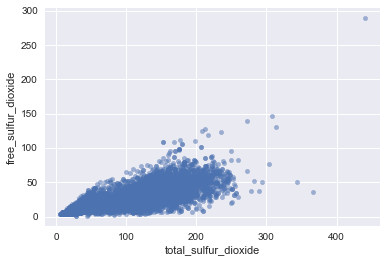

In [5]:
wine.plot(
    kind='scatter', 
    x='total_sulfur_dioxide', 
    y='free_sulfur_dioxide', 
    alpha=0.5, 
    by='class')

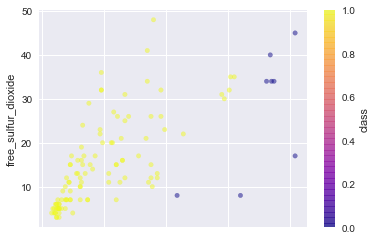

In [6]:
wine[wine.volatile_acidity > 0.8].plot(
    kind='scatter', 
    x='total_sulfur_dioxide', 
    y='free_sulfur_dioxide', 
    c='class', 
    alpha=0.5,  
    colormap='plasma')

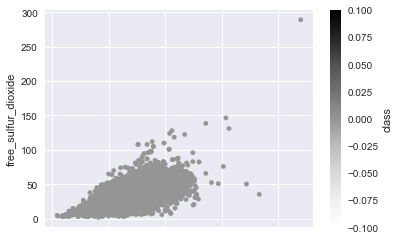

In [7]:
wine[wine['class']==0].plot(kind='scatter', x='total_sulfur_dioxide', y='free_sulfur_dioxide', c='class')

## Comparing feature distributions

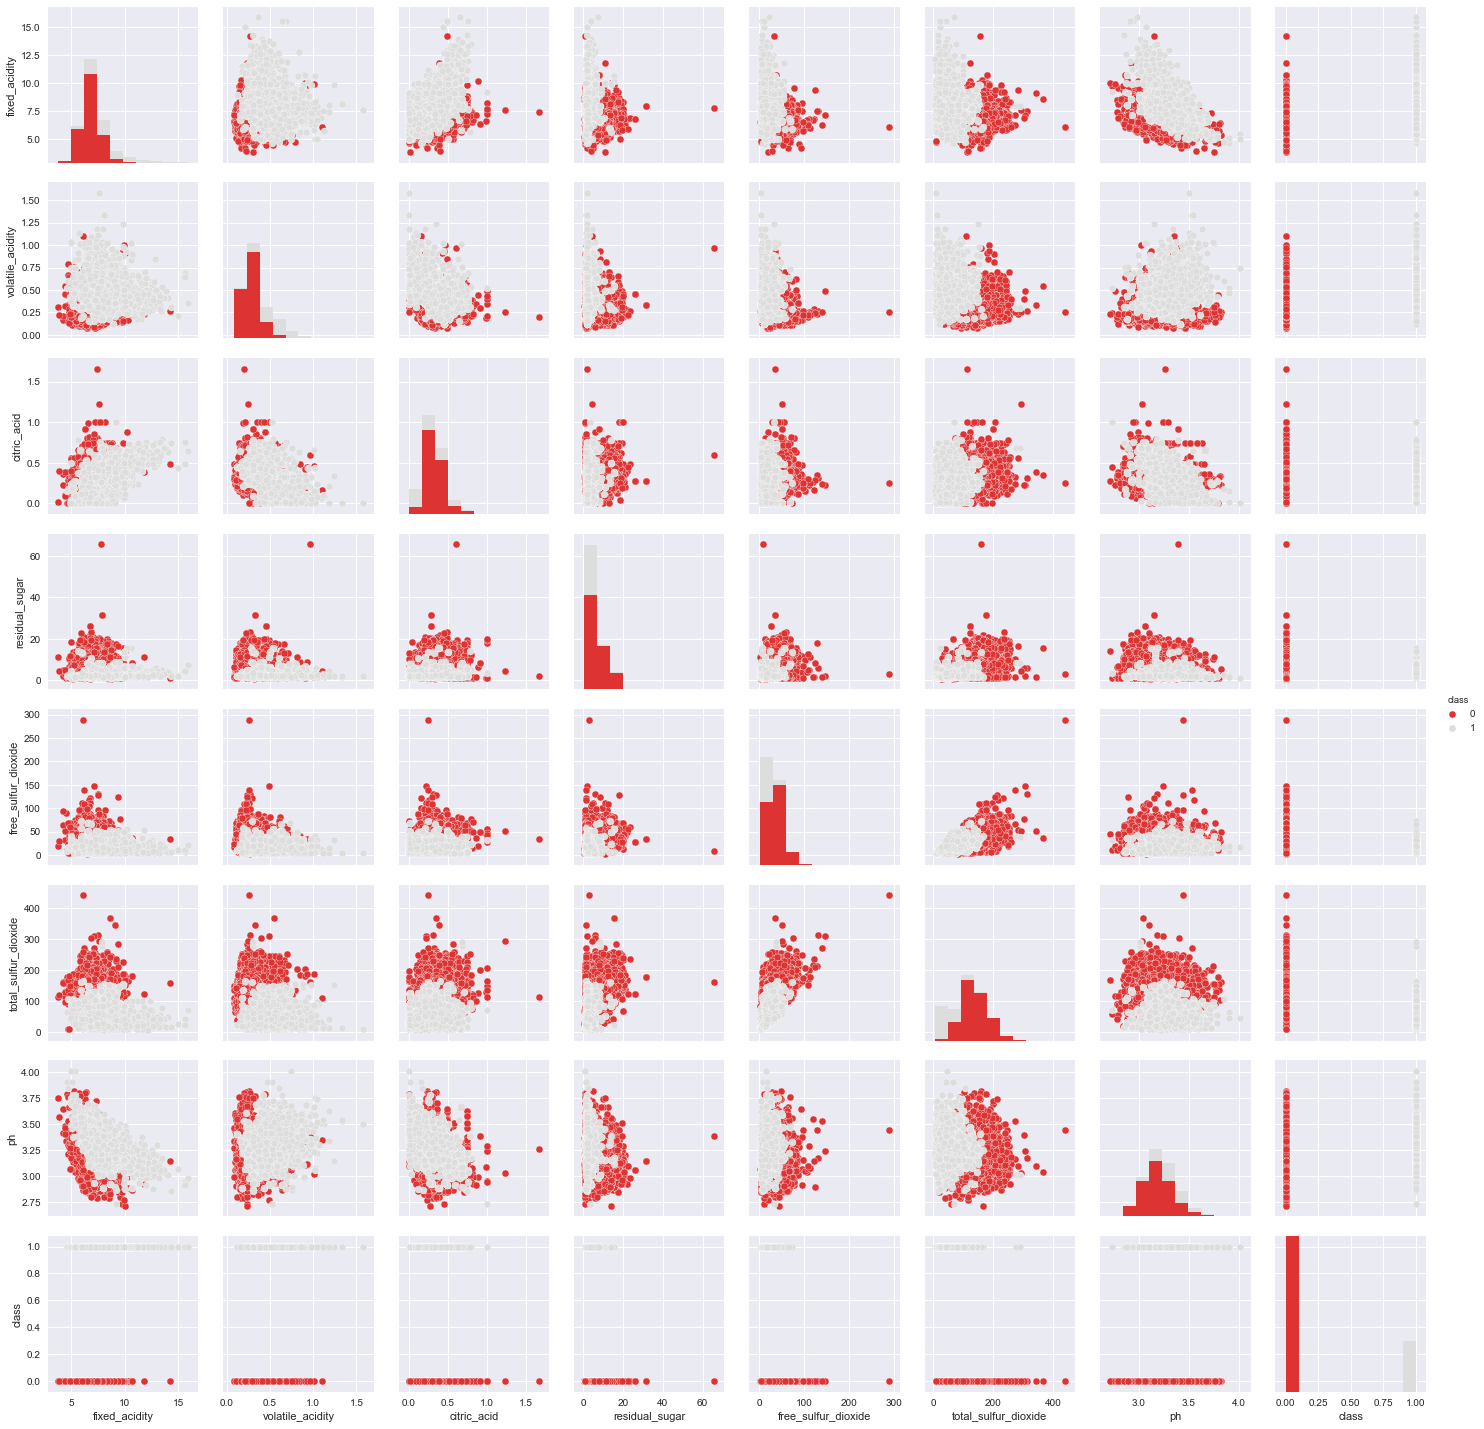

In [8]:
seaborn.pairplot(data=wine, 
                 hue='class', 
                 palette={0: '#dd3333', 1: '#dddddd'})

In [9]:
wine.columns

Index([u'fixed_acidity', u'volatile_acidity', u'citric_acid',
       u'residual_sugar', u'free_sulfur_dioxide', u'total_sulfur_dioxide',
       u'ph', u'class'],
      dtype='object')

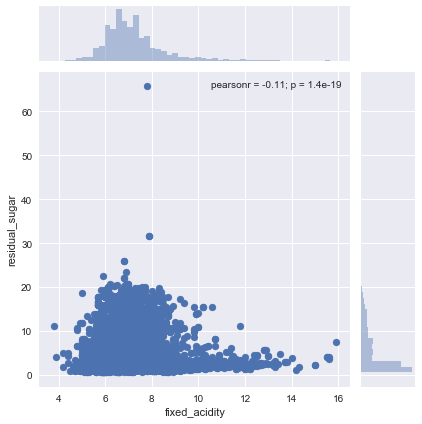

In [10]:
seaborn.jointplot(wine.fixed_acidity, wine.residual_sugar)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13222FF0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x13485170>], dtype=object)

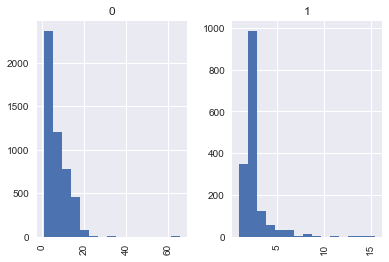

In [11]:
wine.residual_sugar.hist(bins=15, by=wine['class'])

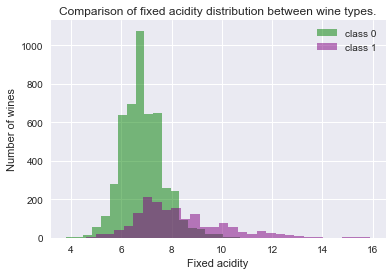

In [12]:
# Another approach with more customization support.
from matplotlib import pyplot

_ = pyplot.hist(wine[wine['class'] == 0].fixed_acidity, bins=30, color='green', alpha=0.5, label='class 0')
_ = pyplot.hist(wine[wine['class'] == 1].fixed_acidity, bins=30, color='purple', alpha=0.5, label='class 1')
pyplot.xlabel('Fixed acidity')
pyplot.ylabel('Number of wines')
pyplot.legend()
pyplot.title('Comparison of fixed acidity distribution between wine types.')

## Building your model

Many different options exist for building a decision tree model: try [sci-kit learn's implementation](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) to start.


### Interesting correlations

Looking at the pairplot, the following pairs seem to have some clear delineations:

pH - Total Sulfur

Really all of the Total Sulfur Relationships seem interesting

Free Sulfur - Sugar

Free Sulfur - Citric Acid

In [13]:
import sklearn.tree

# Run this command with '??' after to get documentation help within jupyter
dtree = sklearn.tree.DecisionTreeClassifier(criterion="entropy")

### Get default code set up

In [14]:
wine_label_col = 'class'
wine_feature_cols = [c for c in wine.columns if c != wine_label_col]

dtree.fit(wine[wine_feature_cols], wine[wine_label_col])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [15]:
class_preds = dtree.predict(wine[wine_feature_cols])
class_preds

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [16]:
num_correct = 0
for pred, actual in zip(class_preds, wine['class']):
    if pred == actual:
        num_correct +=1
print 'Accuracy on training set: %.1f%%' % (num_correct / float(len(wine)) * 100 )


Accuracy on training set: 100.0%


In [17]:
from sklearn import metrics

metrics.roc_auc_score(wine[wine_label_col], class_preds)

0.99958522208270739

## Test/Train Split

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score

train, test = train_test_split(wine, test_size=0.20, random_state=1998)

In [19]:
train[:3]

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,free_sulfur_dioxide,total_sulfur_dioxide,ph,class
2487,7.3,0.26,0.31,1.6,39.0,173.0,3.19,0
4406,7.5,0.18,0.72,9.6,53.0,151.0,3.03,0
4660,6.2,0.25,0.54,7.0,58.0,176.0,3.19,0


In [20]:
test[:3]

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,free_sulfur_dioxide,total_sulfur_dioxide,ph,class
3275,7.0,0.35,0.30,6.5,27.0,87.0,3.40,0
3437,6.5,0.34,0.36,11.0,53.0,247.0,3.44,0
3536,7.3,0.13,0.27,4.6,34.0,172.0,3.23,0


## Train Naive model

In [21]:
dtree = sklearn.tree.DecisionTreeClassifier(criterion="entropy")
dtree.fit(train[wine_feature_cols], train[wine_label_col])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [22]:
class_preds = dtree.predict(test[wine_feature_cols])

metrics.roc_auc_score(test[wine_label_col], class_preds)

0.97273672168862146

### Use only select features

In [23]:
tsd = ['total_sulfur_dioxide', 'ph']
fsd_sugar = ['free_sulfur_dioxide', 'residual_sugar']
fsd_citric = ['free_sulfur_dioxide', 'citric_acid']

In [24]:
scores = cross_val_score(dtree, train[tsd], train[wine_label_col], cv=10)
scores

array([ 0.91362764,  0.90384615,  0.89615385,  0.89807692,  0.91538462,
        0.91538462,  0.89788054,  0.91136802,  0.92100193,  0.88824663])

In [25]:
scores = cross_val_score(dtree, train[fsd_sugar], train[wine_label_col], cv=10)
scores

array([ 0.85028791,  0.85576923,  0.88269231,  0.85      ,  0.84615385,
        0.85769231,  0.86319846,  0.84200385,  0.87668593,  0.83429672])

In [26]:
scores = cross_val_score(dtree, train[fsd_citric], train[wine_label_col], cv=10)
scores

array([ 0.84452975,  0.83461538,  0.85192308,  0.83846154,  0.85961538,
        0.84423077,  0.82851638,  0.82851638,  0.8477842 ,  0.81310212])

#### Summary

Looks like Total Sulfur Dioxide plays an important part in predicting red vs. white.

Still, this single feature is not better than using all of the features together. I will try to engineer a few features. 

In [27]:
wine['bound_sulfur_dioxide'] = wine['total_sulfur_dioxide'] - wine['free_sulfur_dioxide']

In [28]:
wine_label_col = 'class'
wine_feature_cols = [c for c in wine.columns if c != wine_label_col]
wine_feature_cols

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'ph',
 'bound_sulfur_dioxide']

In [29]:
train, test = train_test_split(wine, test_size=0.20, random_state=1998)
train[:3]

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,free_sulfur_dioxide,total_sulfur_dioxide,ph,class,bound_sulfur_dioxide
2487,7.3,0.26,0.31,1.6,39.0,173.0,3.19,0,134.0
4406,7.5,0.18,0.72,9.6,53.0,151.0,3.03,0,98.0
4660,6.2,0.25,0.54,7.0,58.0,176.0,3.19,0,118.0


In [30]:
dtree.fit(train[wine_feature_cols], train[wine_label_col])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [31]:
scores = cross_val_score(dtree, train[wine_feature_cols], train[wine_label_col], cv=10)
scores

array([ 0.9731286 ,  0.97884615,  0.96153846,  0.97115385,  0.97115385,
        0.97115385,  0.97687861,  0.97495183,  0.97880539,  0.96917148])

In [32]:
class_preds = dtree.predict(test[wine_feature_cols])
metrics.roc_auc_score(test[wine_label_col], class_preds)

0.9752955753221938

### Summary

It looks like adding a feature for the number of bound sulfur dioxide molecules helps the model out a little bit. Now I'll do a grid search to find the best paramters for the model.

## Cross-Validation and Grid Search for best parameters

In [33]:
#sklearn.tree.DecisionTreeClassifier??

In [34]:
params = {'criterion': ('gini', 'entropy'),
          'max_depth': range(1,10),
          'class_weight': (None, 'balanced'),
          'presort': (False, True)}

from sklearn.model_selection import GridSearchCV

In [35]:
dtc = sklearn.tree.DecisionTreeClassifier()

In [36]:
clf = GridSearchCV(dtc, params)

In [37]:
clf.fit(train[wine_feature_cols], train[wine_label_col])

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'presort': (False, True), 'criterion': ('gini', 'entropy'), 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'class_weight': (None, 'balanced')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [38]:
clf.best_params_

{'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'presort': False}

In [39]:
clfpreds = clf.predict(test[wine_feature_cols])
metrics.roc_auc_score(test[wine_label_col], clfpreds)

0.96962807102046766

## Summary

Looks like tuning the hyperparameters via grid search didn't help out as much as I'd hoped.

## Visualization of Best Tree

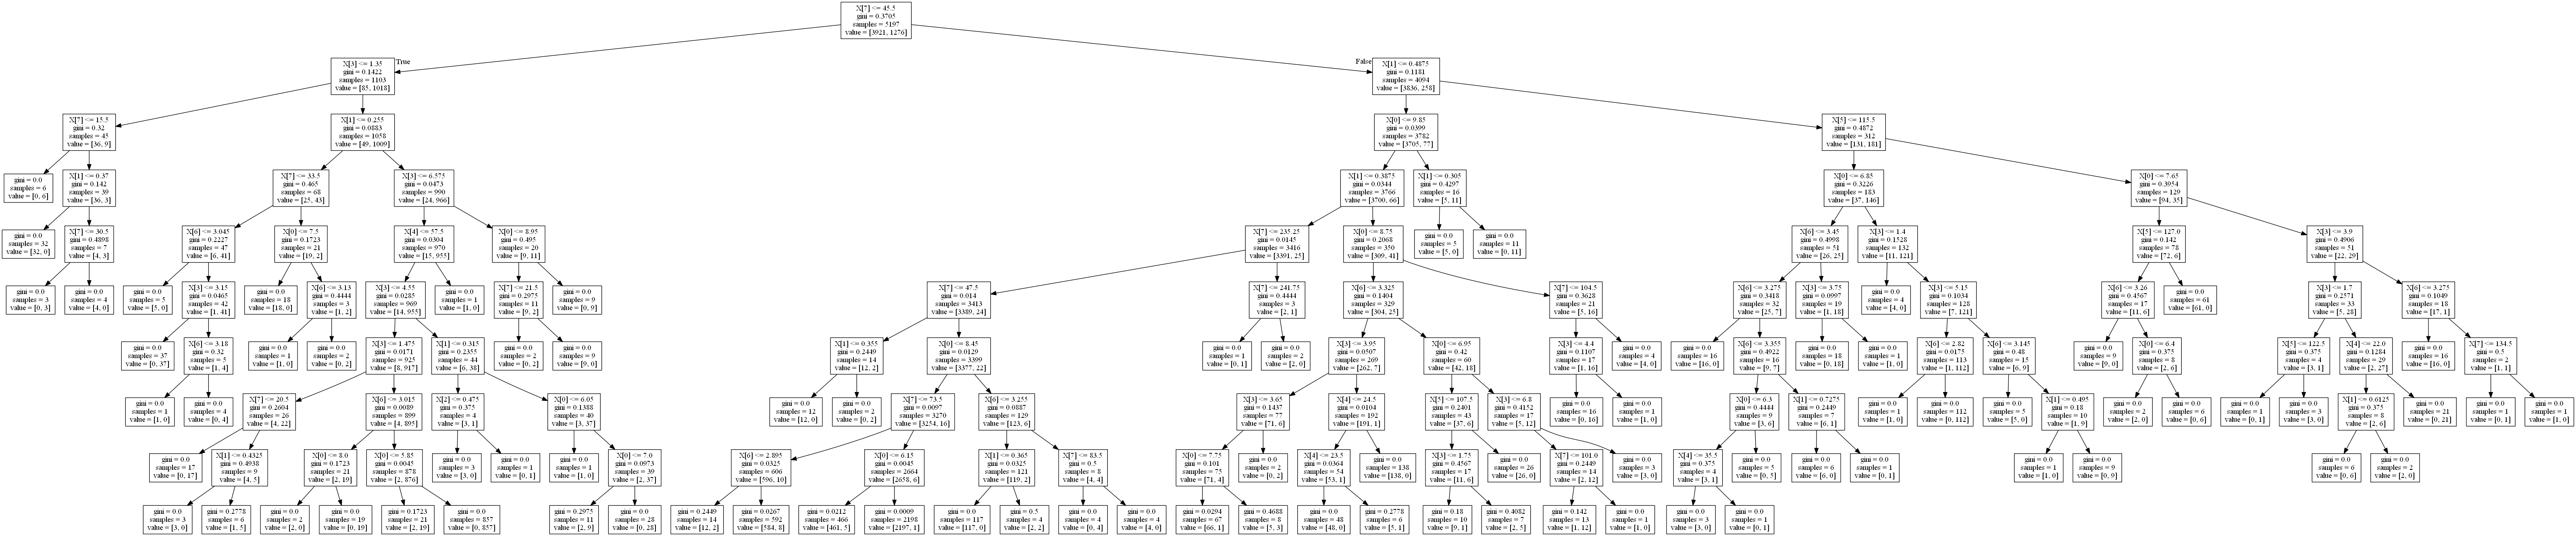

In [40]:
from IPython.display import Image
from StringIO import StringIO
import pydot

import os
os.environ["PATH"] += os.pathsep + 'C:/bin/'

dtree = sklearn.tree.DecisionTreeClassifier(criterion='gini', class_weight=None, max_depth=9, presort=True)
dtree.fit(train[wine_feature_cols], train[wine_label_col])

def tree_viz(sklearn_dtree): 
    temp_buffer = StringIO() # use an in-memory file-like object instead of tmp file 
    sklearn.tree.export_graphviz(sklearn_dtree, out_file=temp_buffer) 
    temp_buffer.seek(0) # rewind the in-memory buffer to start 
    graph, = pydot.graph_from_dot_data(temp_buffer.read())
    return Image(graph.create_png())

tree_viz(dtree)